## Notebook 06 – Sensitivity Analysis

This notebook tests the robustness of the hypothesis by varying volatility window, test length, and regime lag parameters. 3 different values for each parameter are tested via grid search. This notebook then exports the results for downstream analysis. 

This notebook also produces and exports heatmaps for the results.

### Step 0 - Import packages and functions

In [1]:
import sys, os
sys.path.append(os.path.abspath("../src"))
import pandas as pd
import numpy as np
from itertools import product

# Plot packages
import seaborn as sns
import matplotlib.pyplot as plt

# Helper functions to compute regimes, perform walk-foward testing, and bootstrap validation
from regime_definitions import compute_market_volatility_regime, compute_cross_sectional_dispersion_regime
from backtest_engine import model_decile_long_short, walk_forward_model_apply
from stats_helpers import bootstrap_mean_diff   

C:\Users\edzz0\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [17]:
results_df

,vol_window,test_len,lag_days,mean_low,mean_high,mean_diff,pval
0,10,5,0,0.000396,-0.000223,0.000619,0.714
1,10,5,5,0.000233,0.000214,0.000019,0.988
2,10,5,10,0.000078,0.000808,-0.000730,0.641
3,10,21,0,0.000039,0.000023,0.000015,0.989
4,10,21,5,0.000169,-0.000411,0.000580,0.531
5,10,21,10,0.000319,-0.000492,0.000811,0.485
6,10,63,0,0.000053,-0.000016,0.000069,0.859
7,10,63,5,0.000189,-0.000454,0.000643,0.499
8,10,63,10,0.000349,-0.000522,0.000871,0.485
9,21,5,0,-0.000028,0.000072,-0.000100,0.956


### Step 1 - Import prices, momentum, and log returns datasets

In [2]:
# Import prices
price = pd.read_parquet("../data/processed/price_filtered.parquet")

# Import momentum
momentum = pd.read_parquet("../data/processed/momentum.parquet")

# Import log returns
log_returns = pd.read_parquet("../data/processed/log_returns.parquet")

### Step 2 - Define Parameter Grid

In [3]:
vol_windows = [10, 21, 63]  # Volatility window
test_lengths = [5, 21, 63]  # Test length for walk-forward testing
regime_lags = [0, 5, 10]    # regime lag days applied for walk-forward testing

### Step 3 -  Run grid for testing volatility regime

In [4]:
results = []

# loop through different values for volatility window, test lenght, and regime lag days
for vw, tl, lag in product(vol_windows, test_lengths, regime_lags):
    # Compute regime
    regime = compute_market_volatility_regime(log_returns, window=vw)

    # Evaluate walk-forward returns in each regime
    stats = {}
    for reg_label in ["low_vol", "high_vol"]:
        # store walk-forward results
        res = walk_forward_model_apply(
            factor=momentum,
            returns=log_returns,
            regime=regime,
            target_regime=reg_label,
            model_fn = model_decile_long_short,
            lag_days=lag,
            train_window=0,
            test_window=tl,
            step = 21
        )
        # store results
        stats[reg_label] = res

    # Bootstrap difference between regimes
    bootstrap_result = bootstrap_mean_diff(
        stats["low_vol"]["returns"],
        stats["high_vol"]["returns"]
    )
    # get p-value
    diff_pval = bootstrap_result["p_value"]
    # get mean
    diff_mean = bootstrap_result["mean_diff"]
    

    # Store final results for each iteration
    results.append({
        "vol_window": vw,
        "test_len": tl,
        "lag_days": lag,
        "mean_low": stats["low_vol"]["returns"].mean(),
        "mean_high": stats["high_vol"]["returns"].mean(),
        "mean_diff": diff_mean,
        "pval": diff_pval
    })

### Step 4 - Convert volatility regime results to dataframe and output

In [5]:
# Convert to DataFrame and save
results_df = pd.DataFrame(results)

# Save volatility regime grid results as a parquet file
results_df.to_parquet("../data/processed/sensitivity_results.parquet")

### Step 5 - Plot and export heatmaps for volatility regime results

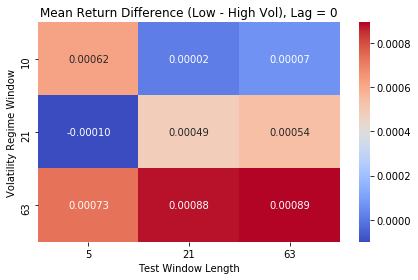

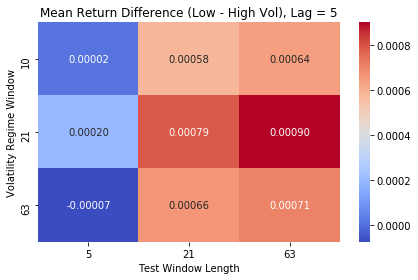

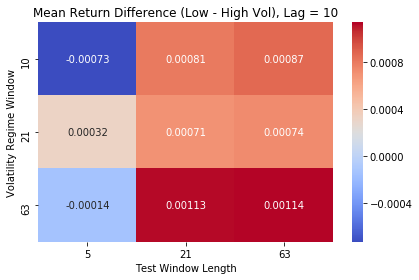

<Figure size 432x288 with 0 Axes>

In [11]:
# Loop through lag days
for lag in results_df['lag_days'].unique():

    pivot = results_df[results_df["lag_days"] == lag].pivot(
        index="vol_window",
        columns="test_len",
        values="mean_diff"
    )

    sns.heatmap(pivot, annot=True, fmt=".5f", cmap="coolwarm")
    plt.title("Mean Return Difference (Low - High Vol), Lag = " + str(lag))
    plt.xlabel("Test Window Length")
    plt.ylabel("Volatility Regime Window")
    plt.tight_layout()
    plt.savefig("../research/plots/heatmap_mean_diff_lag" + str(lag) + ".png")
    plt.show()
    plt.clf()  

### Step 7 -  Run grid for testing dispersion regime

In [13]:
results_disp = []

# loop through different values for volatility window, test lenght, and regime lag days
for vw, tl, lag in product(vol_windows, test_lengths, regime_lags):
    # Compute regime
    regime = compute_cross_sectional_dispersion_regime(log_returns, window=vw)

    # Evaluate walk-forward returns in each regime
    stats = {}
    for reg_label in ["low_disp", "high_disp"]:
        # store walk-forward results
        res = walk_forward_model_apply(
            factor=momentum,
            returns=log_returns,
            regime=regime,
            target_regime=reg_label,
            model_fn = model_decile_long_short,
            lag_days=lag,
            train_window=0,
            test_window=tl,
            step = 21
        )
        # store results
        stats[reg_label] = res

    # Bootstrap difference between regimes
    bootstrap_result = bootstrap_mean_diff(
        stats["low_disp"]["returns"],
        stats["high_disp"]["returns"]
    )
    # get p-value
    diff_pval = bootstrap_result["p_value"]
    # get mean
    diff_mean = bootstrap_result["mean_diff"]
    

    # Store final results for each iteration
    results_disp.append({
        "vol_window": vw,
        "test_len": tl,
        "lag_days": lag,
        "mean_low": stats["low_disp"]["returns"].mean(),
        "mean_high": stats["high_disp"]["returns"].mean(),
        "mean_diff": diff_mean,
        "pval": diff_pval
    })

### Step 8 - Convert dispersion regime results to dataframe and output

In [14]:
# Convert to DataFrame and save
results_disp_df = pd.DataFrame(results_disp)

# Save volatility regime grid results as a parquet file
results_disp_df.to_parquet("../data/processed/sensitivity_results_disp.parquet")

### Step 9 - Plot and export heatmaps for dispersion regime results

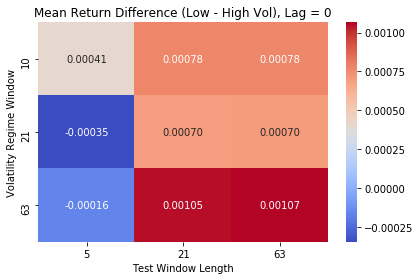

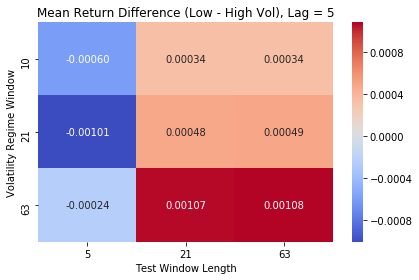

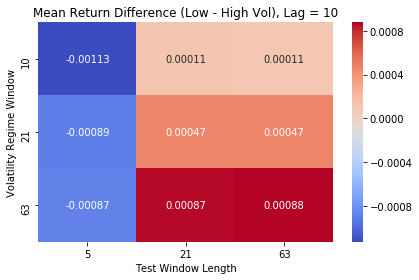

<Figure size 432x288 with 0 Axes>

In [15]:
# Loop through lag days
for lag in results_disp_df['lag_days'].unique():

    pivot = results_disp_df[results_disp_df["lag_days"] == lag].pivot(
        index="vol_window",
        columns="test_len",
        values="mean_diff"
    )

    sns.heatmap(pivot, annot=True, fmt=".5f", cmap="coolwarm")
    plt.title("Mean Return Difference (Low - High Vol), Lag = " + str(lag))
    plt.xlabel("Test Window Length")
    plt.ylabel("Volatility Regime Window")
    plt.tight_layout()
    plt.savefig("../research/plots/heatmap_disp_mean_diff_lag" + str(lag) + ".png")
    plt.show()
    plt.clf()  # ← resets the figure